After rewriting/refactoring of code base, do a test pipeline from start to end to see if everything works in principle.

In [23]:
import json
import logging
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from time import time

import importlib

In [24]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
SEED = 42

In [25]:
from modules import SequenceRepresentation as sr
from modules import ModelDataSet
from modules import ProfileFindingSetup
from modules import plotting_new as plotting
from modules import model_new as model
from modules import training_new as training
from modules import Links
from modules import Streme

importlib.reload(sr)
importlib.reload(ModelDataSet)
importlib.reload(ProfileFindingSetup)
importlib.reload(plotting)
importlib.reload(model)
importlib.reload(Links)
importlib.reload(Streme)

<module 'modules.Streme' from '/home/ebelm/genomegraph/learn_specific_profiles/modules/Streme.py'>

In [26]:
datapath = Path("/home/ebelm/genomegraph/data/241_species/20231123_subset150_NM_RefSeqBest/20240605_fixed_out_subset150_withEnforced_20_15_20_50_15_20_15_20_mammals/exon_chr10_100356531_100356764/")
outpath  = Path("/home/ebelm/genomegraph/runs/20240605_testNewModel/")
os.makedirs(outpath, exist_ok=True)

In [27]:
sequences = sr.loadJSONSequenceList(datapath / "profile_finding_sequence_data.json")

In [28]:
genomes: list[sr.Genome] = []
for seq in sequences:
    # make annotations and transkripts unique
    sr.makeAnnotationsUnique(seq)
    sr.selectLongestTranscript(seq)

    g = sr.Genome()
    g.addSequence(seq)
    genomes.append(g)

INFO:root:[makeAnnotationsUnique] Sequence Fukomys_damarensis:KN123008.1:2,409,178-2,440,546: Found and uniq-ed 0 redundant annotations; removed total of 0 redundant annotations
INFO:root:[selectLongestTranscript] Found and removed subsequence annotations in {sequence}. Removed total of 0 subsequence annotations
INFO:root:[makeAnnotationsUnique] Sequence Cercocebus_atys:KQ012652.1:5,274,598-5,280,660: Found and uniq-ed 1 redundant annotations; removed total of 1 redundant annotations
INFO:root:[makeAnnotationsUnique] Sequence Saimiri_boliviensis:JH378110.1:32,223,310-32,229,802: Found and uniq-ed 1 redundant annotations; removed total of 1 redundant annotations
INFO:root:[makeAnnotationsUnique] Sequence Hipposideros_armiger:JXIK01000029.1:2,457,613-2,462,101: Found and uniq-ed 0 redundant annotations; removed total of 0 redundant annotations
INFO:root:[selectLongestTranscript] Found and removed subsequence annotations in {sequence}. Removed total of 1 subsequence annotations


In [29]:
# debug: overwrite genomes
dbg_datapath = Path("/home/ebelm/genomegraph/runs/20240628_modelVsStreme_newCodebaseTest_cpu/0034_singleExonGenomes.json")
genomes = sr.loadJSONGenomeList(dbg_datapath)

In [30]:
# # shorten data so that it runs faster
# maxgenomes = 5
# maxseqlen = 3000

# genomes = genomes[:maxgenomes]
# for genome in genomes:
#     for seq in genome.sequences:
#         if len(seq) > maxseqlen:
#             d = len(seq) - maxseqlen
#             seq.stripSequence(d, from_start=False)a

In [31]:
# # store shortened data as test genomes for unittests
# with open("/home/ebelm/genomegraph/learn_specific_profiles/tests/testdata.json", 'wt') as fh:
#     json.dump([g.toList() for g in genomes], fh, indent=2)

In [32]:
runID = "0000"
logging.info(f"[main] Start training and evaluation for run {runID}")

# --- train our model (DNA mode) ---
logging.info(f"[main] Start training and evaluation on model for {runID}")
data = ModelDataSet.ModelDataSet(genomes, ModelDataSet.DataMode.Translated,
                                 tiles_per_X = 7, tile_size = 334)
trainsetup = ProfileFindingSetup.ProfileFindingTrainingSetup(data, U = 200, n_best_profiles=2)
trainsetup.initializeProfiles_kmers(enforceU=False, plot=False, overlapTilesize=6)
evaluator = training.MultiTrainingEvaluation()
# try:
training.trainAndEvaluate(runID, trainsetup, evaluator, 
                          outpath, outprefix=f"{runID}_", 
                          rand_seed=SEED)

evaluator.dump(outpath / "evaluator.json")

INFO:root:[main] Start training and evaluation for run 0000
INFO:root:[main] Start training and evaluation on model for 0000


DEBUG:root:[convertModelSites] genomeIdx=1 contigIdx=0 frameIdx=0 tileStartPos=0 tilePos=36 profileIdx=-1 rawpos=36 sitelen=12 this_sitelen=12
DEBUG:root:[convertModelSites] _dbg_seq.id='Mus_musculus:chr17:34,985,149-34,985,406:f0' len(_dbg_seq)=85 _dbg_site='IKLTDISVTDPE' len(_dbg_site)=12
DEBUG:root:[convertModelSites] len(sequence)=257 rc=False dnapos=108 occ_sitelen=36
DEBUG:root:[convertModelSites] genomeIdx=2 contigIdx=0 frameIdx=5 tileStartPos=0 tilePos=35 profileIdx=-1 rawpos=35 sitelen=12 this_sitelen=12
DEBUG:root:[convertModelSites] _dbg_seq.id='Canis_lupus_familiaris:chr12:1,270,842-1,271,279:f5' len(_dbg_seq)=145 _dbg_site='IKLTDISVTDPE' len(_dbg_site)=12
DEBUG:root:[convertModelSites] aa_site_end=47 rc_site_end=143
DEBUG:root:[convertModelSites] len(sequence)=437 rc=True dnapos=142 occ_sitelen=36
DEBUG:root:[convertModelSites] genomeIdx=3 contigIdx=0 frameIdx=0 tileStartPos=0 tilePos=37 profileIdx=-1 rawpos=37 sitelen=12 this_sitelen=12
DEBUG:root:[convertModelSites] _dbg

INFO:root:[main] Start training and evaluation on STREME for 0000
INFO:root:Creating working directory /home/ebelm/genomegraph/runs/20240605_testNewModel/0000_STREME.
INFO:root:STREME took 4.11 seconds.
INFO:root:STREME output: Running 'streme  --p data.fasta --o streme_out --protein --nmotifs 2 --minw 20 --maxw 20'
# Positive sequences "data.fasta" - training: 270 hold-out: 30
# Negative sequences are shuffled primary sequences (0-order) - training: 270 hold-out: 30
# Estimating background model from control sequences.
# Background: A 0.03 C 0.0312 D 0.0314 E 0.0437 F 0.0446 G 0.0804 H 0.0405 I 0.0364 K 0.0475 L 0.11 M 0.0203 N 0.0293 P 0.0803 Q 0.0373 R 0.0671 S 0.0999 T 0.065 V 0.065 W 0.0198 Y 0.0205
# Background order: 0 Background size: 20
# Attempting to trim control hold-out sequences by 1.27% to average primary sequence length (75.2).
# Using Binomial test for p-values because primary and control sequences have
#   different average lengths: 77.3667 vs. 77.2593. Bernoulli = 0.

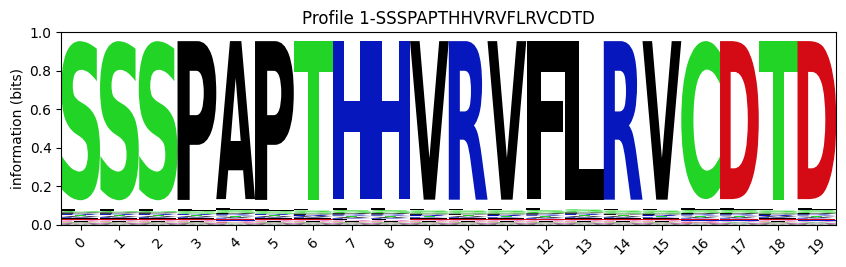

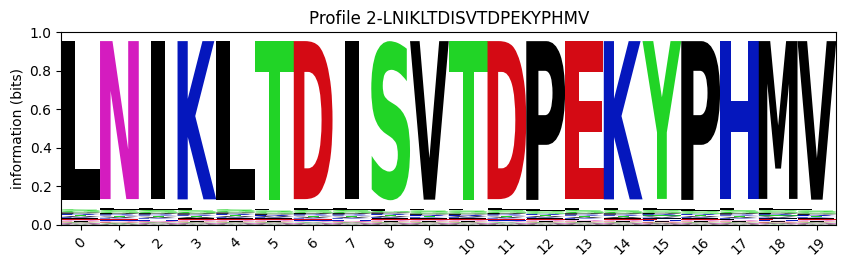

In [33]:
logging.info(f"[main] Start training and evaluation on STREME for {runID}")
streme_wd = outpath / f"{runID}_STREME"
if os.path.exists(streme_wd):
    os.system(f"rm -r {streme_wd}")

streme_runner = Streme.Streme(working_dir = streme_wd,
                              load_streme_script= "/home/ebelm/Software/load_MEME.sh")
data = ModelDataSet.ModelDataSet(genomes, ModelDataSet.DataMode.Translated)
streme_evaluator = training.MultiTrainingEvaluation()

try:
    _ = streme_runner.run(runID, data, streme_evaluator, verbose=True, plot_motifs=True, plot_links=True, plot_onlyLinkedSeqs=False)
except Exception as e:
    logging.error(f"[main] STREME failed for homology {0}, check log for details")
    logging.error(f"[main] Error message: {e}")

    def full_stack():
        import traceback, sys
        exc = sys.exc_info()[0]
        stack = traceback.extract_stack()[:-1]  # last one would be full_stack()
        if exc is not None:  # i.e. an exception is present
            del stack[-1]       # remove call of full_stack, the printed exception
                                # will contain the caught exception caller instead
        trc = 'Traceback (most recent call last):\n'
        stackstr = trc + ''.join(traceback.format_list(stack))
        if exc is not None:
            stackstr += '  ' + traceback.format_exc().lstrip(trc)
        return stackstr

    logging.error(full_stack())
    
streme_evaluator.dump(outpath / "streme_evaluator.json")